In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import pathlib
import glob
import os
import tempfile
import seaborn as sns

In [2]:
# define var for path to image data
train_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/'
validation_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/validation/'
test_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/test/'

In [3]:
#@markdown ### Set image dimensions and batch size
img_height = 160 #@param {type:"number"}
img_width = 160 #@param {type:"number"}
batch_size =  32#@param {type:"number"}

In [4]:
# create training dataset from images in train directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # shuffle=False
)

Found 4269 files belonging to 2 classes.


In [5]:
# create validation dataset from images in validation directory
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 536 files belonging to 2 classes.


In [6]:
# create test dataset from images in test directory
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # shuffle=False
)

Found 535 files belonging to 2 classes.


The documentation for `tf.data.Dataset` objects does not discuss an attribute for class distribution. Taking the length of each class's list of images is a work around to see distribution of classes. 

In [7]:
# generate lists of edible and poisonous mushroom images and print out length of each
images = pathlib.Path(train_dir)
edible_mushrooms = list(images.glob('edible/*'))
poisonous_mushrooms = list(images.glob('poisonous/*'))
print(len(edible_mushrooms), 'edible training images')
print(len(poisonous_mushrooms), 'poisonous training images')

2480 edible training images
1789 poisonous training images


In [8]:
# set input shape based on the channels' order
if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

Let's take a look at the images in this dataset. Below you can see the first nine images from the training set, along with their labels. 

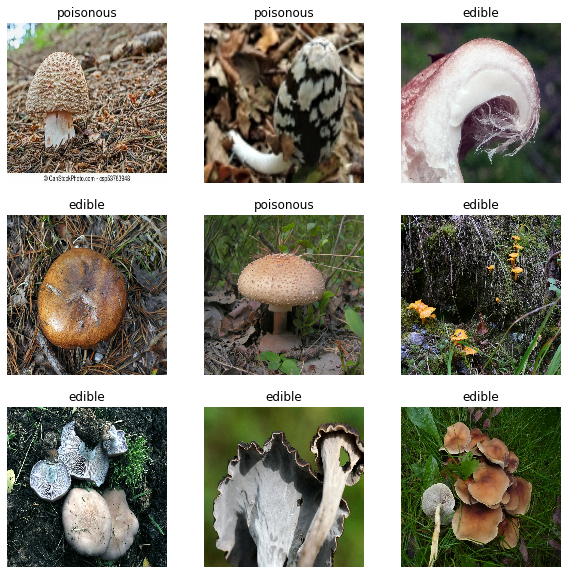

In [9]:
# retrieve class names from dataset
class_names = train_ds.class_names

# plot first 9 images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [10]:
# use buffered prefetching so I/O doesn't become blocking
AUTOTUNE = tf.data.AUTOTUNE

# dataset.cache() keeps images in memory after they're loaded off disk during the first epoch
# dataset.prefetch() overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Since this dataset is very small for deep learning, I'll use data augmentation to increase the number of images my model will have access to. 

Below I've defined an augmentation regimen to be used just for the purpose of visualization. The model will use the same regimen, but augmentation will be done by layers of the model rather than beforehand.

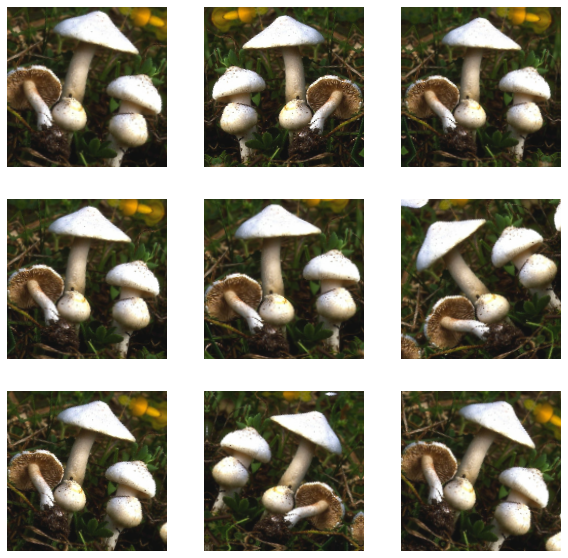

In [12]:
# set augmentation configuration for visualizing transformations
data_augmentation = keras.Sequential([
     layers.experimental.preprocessing.RandomFlip('horizontal'),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1)
])

# run the first training image through the augmentation configuration nine times
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
#@markdown ### Set epochs and learning rate
epochs =  50#@param {type: "number"}
learning_rate =  .0001#@param {type:"number"}

In [12]:
def make_model(learning_rate):
  '''
  Returns a compiled sequential model.

  Arguments:
    learning_rate - learning rate to specify when compiling the model
  '''
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # next three layers are augmentation
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
  ])

  # compile the model
  opt = keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = make_model(learning_rate)
# train model and store as history object
baseline_history = model.fit(
    train_ds,
    epochs=epochs,
    # callbacks=[early_stopping],
    validation_data=validation_ds,
)

Epoch 1/50


In [ ]:
def plot_metrics(history):
  '''
  Plots accuracy and loss over epochs for both training and validation data.

  Arguments:
    history - trained model stored as a history object
  '''
  # get training and validation accuracy from the history object
  tr_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # get training and validation loss from the history object
  tr_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # plot accuracy and loss over epochs
  epochs_range = range(epochs)

  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(history.epoch, tr_acc, label=('Training Accuracy'))
  plt.plot(history.epoch, val_acc, label=('Validation Accuracy'))
  plt.legend(loc='lower right')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy')


  plt.subplot(2,1,2)
  plt.plot(history.epoch, tr_loss, label='Training Loss')
  plt.plot(history.epoch, val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')

  plt.show()

In [ ]:
def plot_cm_cr(model, labels, threshold=0.5):
  '''
  Plots a confusion matrix and classification report given the model and 
  the data's true labels.

  Arguments:
    model - model to print reports for
    labels - true labels for each observation
    threshold - point at which to classify a prediction as positive or negative. 
        Default is .5
  '''
  # get predictions for the validation data
  predictions = model.predict(validation_ds)
  # make predictions into 1s and 0s instead of floats
  preds = tf.where(predictions < threshold, 0, 1)
  # [1 if x > threshold else 0 for x in predictions]
  print('Classification report:\n\n',classification_report(labels, preds))
  print('\n------------------------------------------------\n')

  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Poisonous Mushrooms Identified (True Negatives): ', cm[0][0])
  print('Poisonous Mushrooms Missed (False Positives): ', cm[0][1])
  print('Edible Mushrooms Identified (True Positives): ', cm[1][1])
  print('Edible Mushrooms Missed (False Negatives): ', cm[1][0])

In [ ]:
# plot this model's loss and accuracy
plot_metrics(baseline_history)

In [27]:
# generate list of labels from the validation set
true_labels = tf.concat([y for x, y in validation_ds], axis=0)
# repeat for test set
test_labels = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
# plot the confusion matrix and classification report for this model
plot_cm_cr(model, true_labels)

This model does not perform well at all. It misses more poisonous mushrooms than it correctly identifies. This isn't surprising, given the limited amount of data available. 

When working with small datasets, one option to increase performace is transfer learning. Transfer learning uses a pre-trained model as the base for a new model, and allows the new model to use what the pre-trained model learned from training on large amounts of data.

I'll try using the pre-trained model MobileNetV2 as the base of my model. This model is not as robust as some, but it is considerably lighter and would be more suitable if I were to create a mobile app. MobileNetV2 is trained on images from ImageNet, and has trained on many types of mushrooms before.

To begin the process, I need to rescale the pixel values into the range that MobileNetV2 expects ( [-1, 1] ). The model includes a preprocesser that will do this for me.

In [28]:
# create layer to rescale pixel values using built-in preprocessor
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [29]:
# create base model from MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [30]:
# create augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

The feature extractor below converts each image from its current dimensions (160x160x3) into a block of features with dimensions 5x5x1280.

In [31]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [32]:
# freeze convolutional base so that weights will not be updated during training
base_model.trainable = False

In [33]:
# create layer to average each image's features and convert them into a 1280x1 vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Notice that the Dense layer below does not have an activation function. This is because predictions will be treated as raw prediction values: positive numbers = class 1, negative numbers = class 0.

In [34]:
# Dense layer condenses features into one prediction per image 
prediction_layer = keras.layers.Dense(1) 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Using the Keras Functional API, we can link the all of the layers created above. This API is useful since it allows us to chain together several types of layers.

In [35]:
inputs = keras.Input(shape=(input_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
tl_model = keras.Model(inputs, outputs)

In [36]:
opt = keras.optimizers.Adam(lr=learning_rate)
tl_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
loss0, accuracy0 = tl_model.evaluate(validation_ds)
print('Initial loss: {:.2f}'.format(loss0))
print('Initial accuracy: {:.2f}'.format(accuracy0))

17/17 [==============================] - 2s 16ms/step - loss: 0.6549 - accuracy: 0.7364
Initial loss: 0.88
Initial accuracy: 0.45


In [38]:
transfer_history = tl_model.fit(train_ds,
                             epochs=epochs,
                             validation_data=validation_ds)

Epoch 1/50
134/134 [==============================] - 5s 16ms/step - loss: 0.7697 - accuracy: 0.5074 - val_loss: 0.6705 - val_accuracy: 0.5802
Epoch 2/50
134/134 [==============================] - 2s 15ms/step - loss: 0.7105 - accuracy: 0.5507 - val_loss: 0.6410 - val_accuracy: 0.6157
Epoch 3/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6808 - accuracy: 0.5809 - val_loss: 0.6222 - val_accuracy: 0.6231
Epoch 4/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6626 - accuracy: 0.6044 - val_loss: 0.6091 - val_accuracy: 0.6343
Epoch 5/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6521 - accuracy: 0.5990 - val_loss: 0.5999 - val_accuracy: 0.6623
Epoch 6/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6345 - accuracy: 0.6247 - val_loss: 0.5915 - val_accuracy: 0.6567
Epoch 7/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6191 - accuracy: 0.6341 - val_loss: 0.5856 - val_accuracy: 0.6735

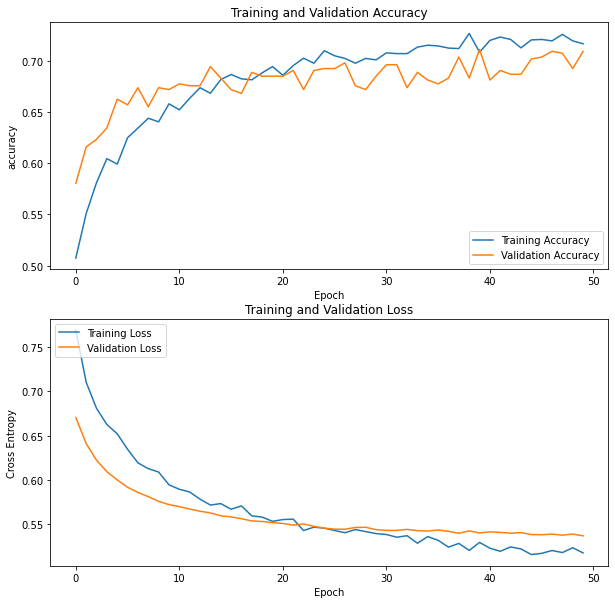

In [39]:
plot_metrics(transfer_history)

Classification report:

               precision    recall  f1-score   support

           0       0.62      0.81      0.70       225
           1       0.82      0.63      0.72       311

    accuracy                           0.71       536
   macro avg       0.72      0.72      0.71       536
weighted avg       0.74      0.71      0.71       536


------------------------------------------------

Poisonous Mushrooms Identified (True Negatives):  183
Poisonous Mushrooms Missed (False Positives):  42
Edible Mushrooms Identified (True Positives):  197
Edible Mushrooms Missed (False Negatives):  114


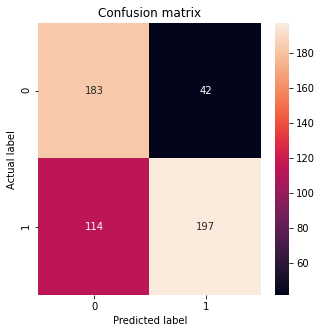

In [40]:
plot_cm_cr(tl_model, true_labels)

In [41]:
base_model.trainable = True

In [42]:
# print out number of layers in base model
print('The base model has {} layers'.format(len(base_model.layers)))

# fine-tune layers after this
fine_tune_at = 100

# freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

The base model has 154 layers


In [43]:
# using a smaller learning rate here so the model does not overfit
tl_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])

In [44]:
# set up early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # use validation accuracy as monitor
    verbose=1, 
    patience=3, # wait x epochs before early stop
    mode='max', # training will stop when val_accuracy hasn't increased in (patience) epochs
    restore_best_weights=True # restore weights from epoch where model performed best
)

In [45]:
total_epochs = epochs+10
fine_tune_history = tl_model.fit(train_ds,
                              epochs=total_epochs,
                              # callbacks=[early_stopping],
                              initial_epoch=transfer_history.epoch[-1],
                              validation_data=validation_ds)

Epoch 50/60
134/134 [==============================] - 8s 28ms/step - loss: 0.5283 - accuracy: 0.7235 - val_loss: 0.5191 - val_accuracy: 0.7332
Epoch 51/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4984 - accuracy: 0.7434 - val_loss: 0.5259 - val_accuracy: 0.7164
Epoch 52/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4864 - accuracy: 0.7409 - val_loss: 0.5277 - val_accuracy: 0.7090
Epoch 53/60
134/134 [==============================] - 3s 23ms/step - loss: 0.4432 - accuracy: 0.7774 - val_loss: 0.5028 - val_accuracy: 0.7463
Epoch 54/60
134/134 [==============================] - 3s 23ms/step - loss: 0.4325 - accuracy: 0.7825 - val_loss: 0.4907 - val_accuracy: 0.7463
Epoch 55/60
134/134 [==============================] - 3s 24ms/step - loss: 0.4208 - accuracy: 0.7851 - val_loss: 0.5023 - val_accuracy: 0.7351
Epoch 56/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4222 - accuracy: 0.7910 - val_loss: 0.5038 - val_accuracy:

In [48]:
# plot_metrics(fine_tune_history)

In [54]:
acc = transfer_history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = transfer_history.history['loss'] + fine_tune_history.history['loss']
val_loss = transfer_history.history['val_loss'] + fine_tune_history.history['val_loss']

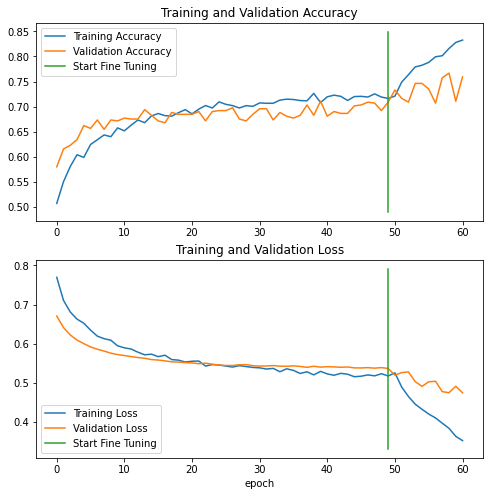

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([epochs-1,epochs-1],
          plt.ylim(), 
         label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), 
         label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Classification report:

               precision    recall  f1-score   support

           0       0.74      0.74      0.74       225
           1       0.81      0.82      0.81       311

    accuracy                           0.78       536
   macro avg       0.78      0.78      0.78       536
weighted avg       0.78      0.78      0.78       536


------------------------------------------------

Poisonous Mushrooms Identified (True Negatives):  166
Poisonous Mushrooms Missed (False Positives):  59
Edible Mushrooms Identified (True Positives):  254
Edible Mushrooms Missed (False Negatives):  57


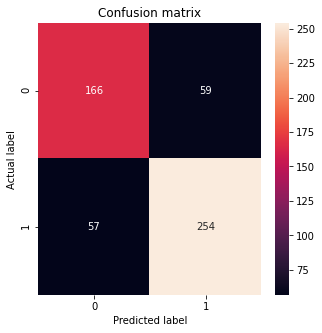

In [57]:
predictions = tl_model.predict(validation_ds)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Classification report:\n\n',classification_report(true_labels, predictions))
print('\n------------------------------------------------\n')

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Poisonous Mushrooms Identified (True Negatives): ', cm[0][0])
print('Poisonous Mushrooms Missed (False Positives): ', cm[0][1])
print('Edible Mushrooms Identified (True Positives): ', cm[1][1])
print('Edible Mushrooms Missed (False Negatives): ', cm[1][0])

Classification report:

               precision    recall  f1-score   support

           0       0.68      0.81      0.74       225
           1       0.84      0.72      0.78       311

    accuracy                           0.76       536
   macro avg       0.76      0.77      0.76       536
weighted avg       0.77      0.76      0.76       536


------------------------------------------------

Poisonous Mushrooms Identified (True Negatives):  183
Poisonous Mushrooms Missed (False Positives):  42
Edible Mushrooms Identified (True Positives):  224
Edible Mushrooms Missed (False Negatives):  87


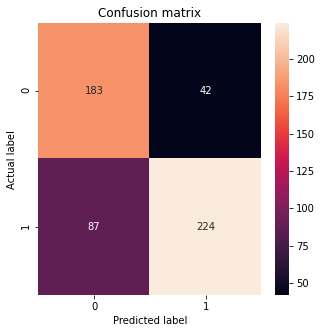

In [50]:
plot_cm_cr(tl_model, true_labels)

Classification report:

               precision    recall  f1-score   support

           0       0.76      0.77      0.77       225
           1       0.83      0.82      0.83       310

    accuracy                           0.80       535
   macro avg       0.80      0.80      0.80       535
weighted avg       0.80      0.80      0.80       535


------------------------------------------------

Poisonous Mushrooms Identified (True Negatives):  174
Poisonous Mushrooms Missed (False Positives):  51
Edible Mushrooms Identified (True Positives):  255
Edible Mushrooms Missed (False Negatives):  55


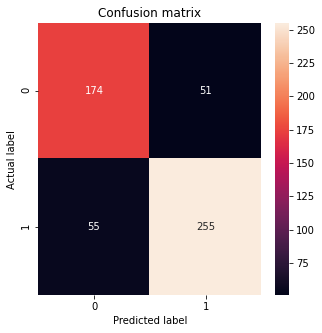

In [46]:
predictions = tl_model.predict(test_ds)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Classification report:\n\n',classification_report(test_labels, predictions))
print('\n------------------------------------------------\n')

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Poisonous Mushrooms Identified (True Negatives): ', cm[0][0])
print('Poisonous Mushrooms Missed (False Positives): ', cm[0][1])
print('Edible Mushrooms Identified (True Positives): ', cm[1][1])
print('Edible Mushrooms Missed (False Negatives): ', cm[1][0])

Predictions:
 [1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1]
Labels:
 [1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0]


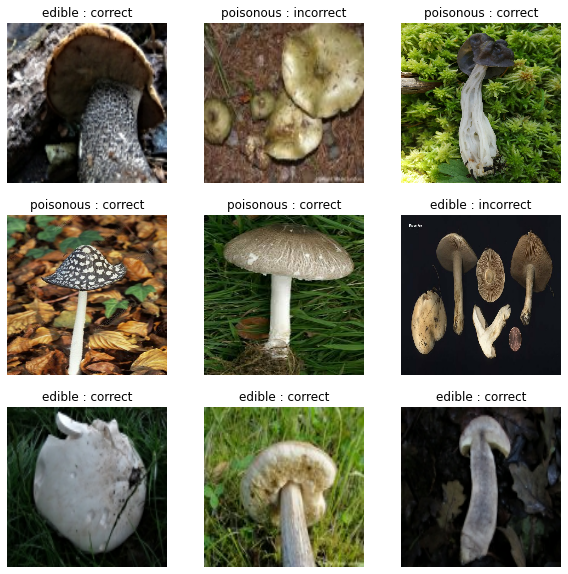

In [50]:
# retrieve batch of images from test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = tl_model.predict_on_batch(image_batch).flatten()

# apply sigmoid since model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  if class_names[predictions[i]] == class_names[label_batch[i]]:
    plt.title('{} : correct'.format(class_names[predictions[i]]))
  else:
    plt.title('{} : incorrect'.format(class_names[predictions[i]]))
  plt.axis('off')

In [ ]:
predictions = tl_model.predict(validation_ds)
preds = np.argmax(predictions, axis=1)

In [ ]:
print('Classification report:\n\n',classification_report(true_labels, preds))
print('\n------------------------------------------------\n')

cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Poisonous Mushrooms Identified (True Negatives): ', cm[0][0])
print('Poisonous Mushrooms Missed (False Positives): ', cm[0][1])
print('Edible Mushrooms Identified (True Positives): ', cm[1][1])
print('Edible Mushrooms Missed (False Negatives): ', cm[1][0])
print('Total Poisonous Mushrooms: ', np.sum(cm[0]))